In [1]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob
import pickle
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.linear_model import LinearRegression
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

# Get Key Files

### Full Multi-Task Data
Here, there is one row per stage. Each row explains how a particular team did on a particular task with a particular complexity.

In [3]:
# full multi-task data
full_multi_task_data = pd.read_csv('../tpm-data/raw_data/full_multi_task_data.csv').rename(columns={"task": "task_name"})
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)
full_multi_task_data.head()

,task_name,complexity,stageId,playerCount,score
0,Writing Story,Medium,22bJZWfgB3gfKXY6A,6,100.000000
1,Writing Story,Low,22wFrSqgf8ESM8pNY,3,100.000000
2,Divergent Association,Medium,24uBQrHu4jKFgGQ24,1,83.248037
3,Moral Reasoning,High,26RnwcdY842ZGSQtT,3,50.000000
4,Room Assignment,High,28b6Y5xQDcrdFZK2h,1,88.659794


### Task Map

In [4]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [5]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole"
}

In [6]:
# make the names match
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

## Get Team Data

### SET WHAT YOU ARE GROUPING BY HERE

In [7]:
# GROUPING_COLS = ["task_name", "complexity", "playerCount"]
# GROUPING_COLS = ["task_name", "playerCount"]
GROUPING_COLS = ["task_name"]

In [8]:
complexity_columns = ["High", "Low", "Medium"]

full_multi_task_data["team"] = np.where(full_multi_task_data["playerCount"] > 1, True, False)
team_multi_task_data = full_multi_task_data[full_multi_task_data["team"] == True]
grouped_performance_by_task = pd.DataFrame(team_multi_task_data.groupby(GROUPING_COLS)["score"].agg("mean")).reset_index()

if "complexity" in GROUPING_COLS:
    grouped_performance_by_task = pd.get_dummies(grouped_performance_by_task, columns = ["complexity"]).rename(columns = {"complexity_High": "High", "complexity_Low": "Low", "complexity_Medium": "Medium"})
    grouped_performance_by_task[complexity_columns] = grouped_performance_by_task[complexity_columns].astype(int)

### This is main data DF --
grouped_performance_with_task_cols = pd.merge(left = grouped_performance_by_task, right = task_map, on = "task_name", how = "left")

### Stage-based data

For teams, here we get information on:
- Player Composition
- Communication (chat) features

In [9]:
# read in some scores from one of our pickle files
# NOTE: the noncumulative version slices by the STAGE, which means we get the discussion relevant to the task complexity as well
with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
	stage_based_data = pickle.load(cleaned_pickle_file)

In [10]:
stage_based_data.data.loc[:, "task_name"] = stage_based_data.data["task"].replace(task_name_mapping)
stage_based_data.data.drop("task", axis =1, inplace=True)
targets = stage_based_data.dvs
tasks = stage_based_data.task_name

# Get a sense of how many observations we have

In [11]:
full_multi_task_data.groupby(["task_name", "complexity", "playerCount"]).size().reset_index(name='num_observations').head(30)

,task_name,complexity,playerCount,num_observations
0,Allocating resources to programs,High,1,50
1,Allocating resources to programs,High,3,31
2,Allocating resources to programs,High,6,26
3,Allocating resources to programs,Low,1,50
4,Allocating resources to programs,Low,3,31
5,Allocating resources to programs,Low,6,26
6,Allocating resources to programs,Medium,1,50
7,Allocating resources to programs,Medium,3,31
8,Allocating resources to programs,Medium,6,26
9,Divergent Association Task,High,1,29


# Calculate Synergy
> take score and for every team choose a random group of individuals of the same team size, then from that group select the best individual and a random individual.

> Synergy is then:

> strong if the team is better than the best individual

> weak if the team is not better than the best individual but better than the random one


In [12]:
individual_multi_task_data = full_multi_task_data[full_multi_task_data["team"]==False]
individual_multi_task_data.head()

,task_name,complexity,stageId,playerCount,score,team
2,Divergent Association Task,Medium,24uBQrHu4jKFgGQ24,1,83.248037,False
4,Room assignment task,High,28b6Y5xQDcrdFZK2h,1,88.659794,False
5,"Wolf, goat and cabbage transfer",High,297T4k8D3YuCqKYgk,1,0.000000,False
6,"Wolf, goat and cabbage transfer",Medium,2AnaRvyyBhKYYz3bv,1,43.000000,False
8,Allocating resources to programs,Medium,2DLuipD5F9zFmC3BP,1,90.000000,False


In [13]:
def get_nominal_team(task_name, playerCount, complexity = None):
    if complexity is not None:
        individuals_for_task_and_complexity = individual_multi_task_data[(individual_multi_task_data["task_name"] == task_name) & (individual_multi_task_data["complexity"] == complexity)]
    else:
        individuals_for_task_and_complexity = individual_multi_task_data[(individual_multi_task_data["task_name"] == task_name)]
    return individuals_for_task_and_complexity.sample(n = playerCount, replace = True)

In [14]:
def get_best_and_random_individual(task_name, playerCount, complexity):
    nominal_team_scores = get_nominal_team(task_name, playerCount, complexity)["score"]
    return(np.max(nominal_team_scores), random.choice(list(nominal_team_scores)))

In [15]:
def get_synergy_for_groups(complexity = True, playerCount = True):
    grouped_performance_with_task_cols["strong_synergy"] = np.zeros(len(grouped_performance_with_task_cols))
    grouped_performance_with_task_cols["weak_synergy"] = np.zeros(len(grouped_performance_with_task_cols))

    for i, row in grouped_performance_with_task_cols.iterrows():

        if(complexity):
            if row["High"] == 1:
                complexity = "High"
            elif row["Medium"] == 1:
                complexity = "Medium"
            else:
                complexity = "Low"
        else:
            complexity = None
        
        task_name = row["task_name"]
        if(playerCount):
            playerCount_value = row["playerCount"]
        average_team_score = row["score"]

        best_individual_scores = []
        random_individual_scores = []
        for j in range(1000): # bootstrap 1,000 times
            if(not playerCount):
                playerCount_value = random.choice([3,6]) # we randomly choose 3 or 6 to simulate the real times, if we don't take playerCount into consideration
            best_score, random_score = get_best_and_random_individual(task_name, playerCount_value, complexity)
            best_individual_scores.append(best_score)
            random_individual_scores.append(random_score)

        # update the original dataframe
        grouped_performance_with_task_cols.loc[i, "strong_synergy"] = average_team_score / np.mean(best_individual_scores)
        grouped_performance_with_task_cols.loc[i, "weak_synergy"] = average_team_score / np.mean(random_individual_scores)

In [16]:
complexity = True if "complexity" in GROUPING_COLS else False
playerCount = True if "playerCount" in GROUPING_COLS else False

get_synergy_for_groups(complexity = complexity, playerCount=playerCount)

## Exploratory Heatmap Plots

In [17]:
task_cols = task_map.drop("task_name", axis = 1).columns

In [18]:
def plot_correlation_heatmap(correlation_matrix, y_cols, feature_name):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(correlation_matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(task_cols)))
    ax.set_xticklabels(task_cols, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(y_cols)), labels=y_cols)

    ax.set_title("Correlation Between " + feature_name + " & Task Feature")

    # Add shorter and horizontal colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink = 0.6)
    cbar.set_label('Correlation')

    fig.tight_layout()
    plt.show()

In [19]:
def get_correlations_per_task_complexity(dv, dv_label):    
    dv_to_task_correlation = []

    for complexity in ["Low", "Medium", "High"]:
        dv_by_task_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
        within_complexity_arr = []
        for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
            correlation = np.corrcoef(dv_by_task_for_complexity[dv], dv_by_task_for_complexity[col])[0][1]
            within_complexity_arr.append(correlation)

        dv_to_task_correlation.append(within_complexity_arr)
    plot_correlation_heatmap(dv_to_task_correlation, complexity_columns, dv_label)

In [20]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("strong_synergy", "Strong Synergy")

In [21]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("weak_synergy", "Weak Synergy")

## Add in Communication Features

In [22]:
comms_features = stage_based_data.data.groupby(GROUPING_COLS)[["gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]].agg("mean").reset_index()
overlapping_columns = set(comms_features.columns).intersection(grouped_performance_with_task_cols.columns)
comms_features = comms_features.drop(list(overlapping_columns), axis = 1)
grouped_performance_with_task_cols = pd.concat([grouped_performance_with_task_cols,comms_features], axis = 1)

In [23]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("gini_coefficient_sum_num_messages", "Gini Coefficient")

In [24]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("sum_num_words", "Total Number of Words")

In [25]:
if "complexity" in GROUPING_COLS:
    get_correlations_per_task_complexity("average_positive_bert", "Average Message Positivity")

## Recreation of PCA Plot (Figure 4) with Real Data

In [26]:
task_cols_to_use = task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis = 1).columns

In [27]:
numeric_columns = [col for col in grouped_performance_with_task_cols.columns if (grouped_performance_with_task_cols[col].dtype == "int64" or grouped_performance_with_task_cols[col].dtype == "float64")]

In [28]:
grouped_avg_all_tasks = grouped_performance_with_task_cols.groupby("task_name")[numeric_columns].agg("mean").reset_index()

In [29]:
# Normalize task columns
normalized_df = grouped_avg_all_tasks.copy()
normalized_df[task_cols_to_use] = normalized_df[task_cols_to_use].transform(lambda x: (x - x.mean()) / x.std())

pca = PCA(n_components=2)
pca_for_multitask_data = pca.fit_transform(normalized_df[task_cols_to_use])

In [30]:
pca_df = pd.DataFrame(data=pca_for_multitask_data, columns=["PC1", "PC2"])

In [31]:
# dependent variables of interest
pca_df["synergy"] = grouped_avg_all_tasks["strong_synergy"]
pca_df["gini_coefficient"] = grouped_avg_all_tasks["gini_coefficient_sum_num_messages"]
pca_df["total_words"] = grouped_avg_all_tasks["sum_num_words"]
pca_df["average_positivity"] = grouped_avg_all_tasks["average_positive_bert"]

# concatenate task names so that they can be included as labels
pca_df = pd.concat([pca_df, grouped_avg_all_tasks["task_name"]], axis=1)

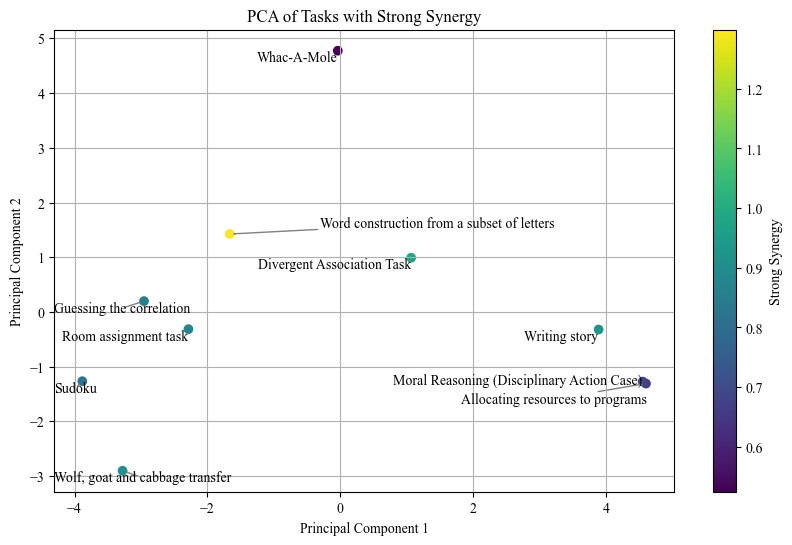

In [32]:
def plot_pca_scatter_with_labels(pca_df, dv, dv_label):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df[dv])

    plt.title("PCA of Tasks with " + dv_label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    cbar = plt.colorbar(scatter, label=dv_label)

    texts = []
    for i, txt in enumerate(pca_df["task_name"]):
        texts.append(plt.text(pca_df["PC1"].iloc[i], pca_df["PC2"].iloc[i], txt, ha='left'))

    # adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.grid(True)

    plt.show()

plot_pca_scatter_with_labels(pca_df, dv = "synergy", dv_label="Strong Synergy")

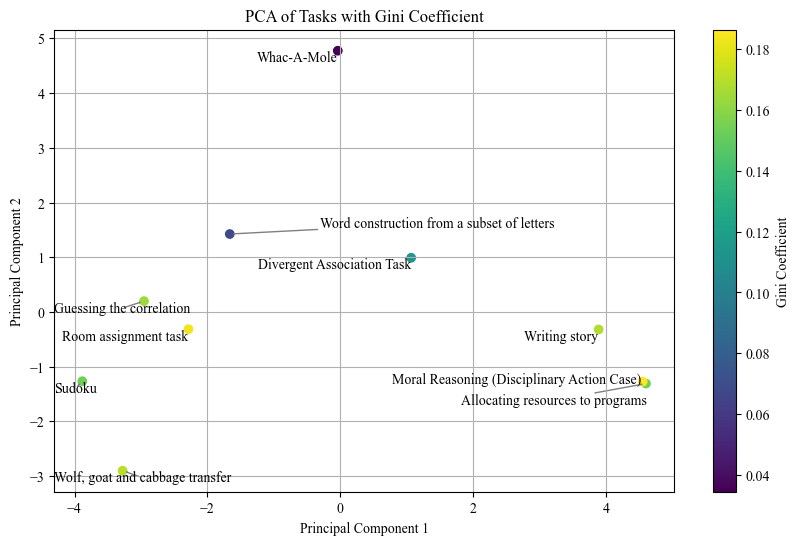

In [33]:
plot_pca_scatter_with_labels(pca_df, dv = "gini_coefficient", dv_label="Gini Coefficient")

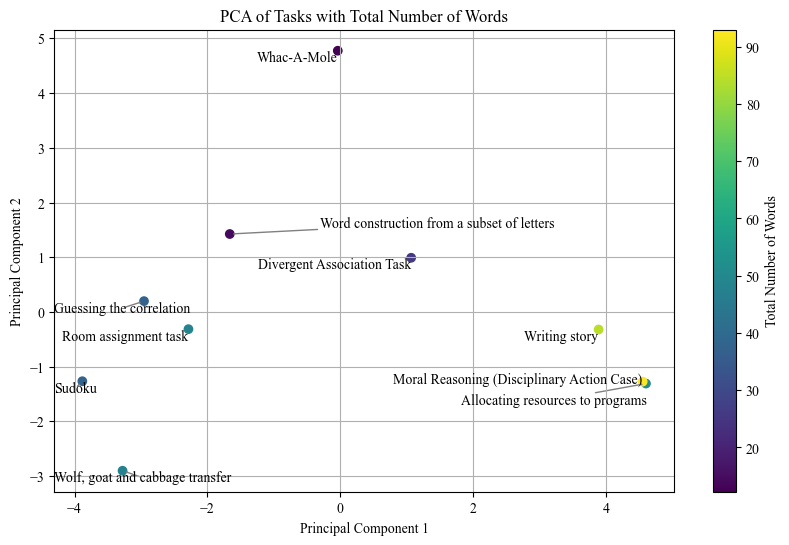

In [34]:
plot_pca_scatter_with_labels(pca_df, dv = "total_words", dv_label="Total Number of Words")

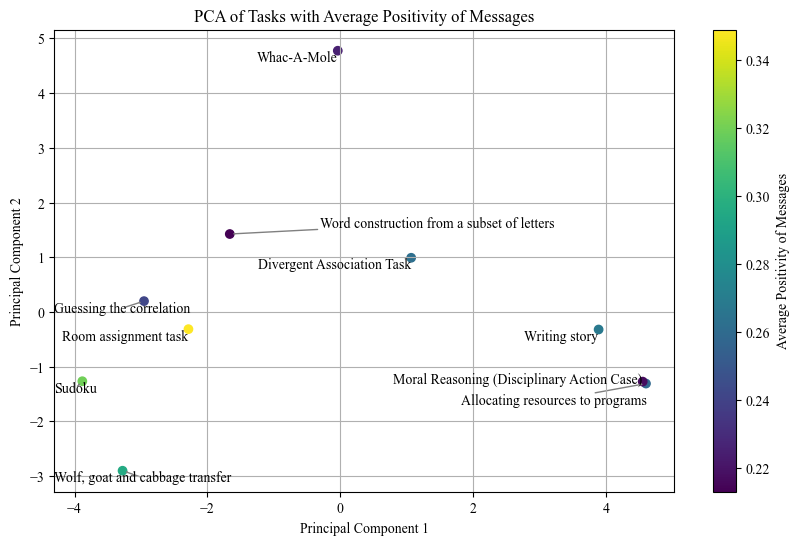

In [35]:
plot_pca_scatter_with_labels(pca_df, dv = "average_positivity", dv_label="Average Positivity of Messages")

# Regression of Features
> Try training a logistic regression model on each feature individually and ranking the features based on their performance in predicting the different outcomes. This is similar to the correlation exercise but more on predictive value.

In [36]:
if "complexity" in GROUPING_COLS and "playerCount" in GROUPING_COLS:   
    regression_covariates_task_and_complexity = list(task_cols_to_use) + complexity_columns + ["playerCount"]

In [37]:
if "complexity" in GROUPING_COLS:
    strong_synergy_lm = sm.OLS(endog= grouped_performance_with_task_cols["strong_synergy"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity])).fit()
    weak_synergy_lm = sm.OLS(endog= grouped_performance_with_task_cols["weak_synergy"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity])).fit()
    gini_coefficient_lm = sm.OLS(endog= grouped_performance_with_task_cols["gini_coefficient_sum_num_messages"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity])).fit()
    sum_words_lm = sm.OLS(endog= grouped_performance_with_task_cols["sum_num_words"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity])).fit()
    positivity_lm = sm.OLS(endog= grouped_performance_with_task_cols["average_positive_bert"], exog=sm.add_constant(grouped_performance_with_task_cols[regression_covariates_task_and_complexity])).fit()

    stargazer = Stargazer([strong_synergy_lm, weak_synergy_lm, gini_coefficient_lm, sum_words_lm, positivity_lm])
    stargazer.custom_columns(['Strong Synergy', 'Weak Synergy', 'Gini Coefficient', 'Total Number of Words', 'Average Positivity of Messages'], [1, 1, 1, 1, 1])
    stargazer

In [82]:
def plot_q2_heatmap(q2_matrix, y_cols, feature_name):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(q2_matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(task_cols)))
    ax.set_xticklabels(task_cols, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(y_cols)), labels=y_cols)

    ax.set_title("Q^2 for Single Variate Between " + feature_name + " & Task Feature")

    # Add shorter and horizontal colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink = 0.6)
    cbar.set_label('Q^2')

    fig.tight_layout()
    plt.show()

In [39]:
def get_q2(y, x):
    
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    for i in range(len(y)):
        y_test = y.iloc[[i]]
        x_test = x.iloc[[i]]
        y_train = y.drop(index=y.index[i]).reset_index(drop=True)
        x_train = x.drop(index=x.index[i]).reset_index(drop=True)
        
        if len(x_train) == 0:
            # Skip iteration if the training set is empty after dropping the row
            continue

        x_train_array = np.asarray(x_train).reshape(-1, 1)
        y_train_array = np.asarray(y_train).reshape(-1, 1)

        x_test_array = np.asarray(x_test).reshape(-1, 1)  # Ensure x_test is 2D
        y_test_array = np.asarray(y_test).reshape(-1, 1)

        fitted_model = LinearRegression().fit(X=x_train_array, y=y_train_array)

        # save prediction error
        prediction = fitted_model.predict(x_test_array)[0]
        squared_model_prediction_errors.append((y_test_array - prediction) ** 2)

        # save total error for this fold
        squared_average_prediction_errors.append((y_test_array - np.mean(y_train_array)) ** 2)

    return 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))

In [40]:
def get_q2_per_task_complexity(dv, dv_label):    
    dv_to_task_q2 = []

    for complexity in ["Low", "Medium", "High"]:
        dv_by_task_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
        within_complexity_arr = []
        for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
            q2 = get_q2(dv_by_task_for_complexity[dv], dv_by_task_for_complexity[col])
            within_complexity_arr.append(q2)

        dv_to_task_q2.append(within_complexity_arr)
    plot_q2_heatmap(dv_to_task_q2, complexity_columns, dv_label)

In [41]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("strong_synergy", "Strong Synergy")

In [42]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("weak_synergy", "Weak Synergy")

In [43]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("gini_coefficient_sum_num_messages", "Gini Coefficient")

In [44]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("sum_num_words", "Total Number of Words")

In [45]:
if "complexity" in GROUPING_COLS:
    get_q2_per_task_complexity("average_positive_bert", "Average Message Positivity")

>  heatmap with x task features and y outcome (synegy, gini) and avging over task complexity.. x axis ordered by avg q^2 across outcomes

#### NOTE: this code should be run after grouping ONLY by "task_name" (and not by playerCount or complexity)
Otherwise, it weights each group evenly (rather than by the number of observations in each group)

In [46]:
aggregated_performance_by_task = grouped_performance_with_task_cols.groupby("task_name")[["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"] + list(task_cols_to_use)].agg("mean").reset_index()

In [47]:
q_2_for_all_dvs = []
dvs = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"]
for dv in dvs:
    within_dv_arr = []
    for col in task_cols_to_use:
        # get the q2 for each
        q2 = get_q2(aggregated_performance_by_task[dv], aggregated_performance_by_task[col])
        within_dv_arr.append(q2)

    q_2_for_all_dvs.append(within_dv_arr)

In [48]:
q2_by_dv_df = pd.DataFrame(q_2_for_all_dvs, columns=task_cols_to_use, index = ["strong_synergy", "weak_synergy", "gini_coefficient_sum_num_messages", "average_positive_bert", "sum_num_words"])
# sort by average
q2_by_dv_df = q2_by_dv_df.reindex(q2_by_dv_df.mean().sort_values(ascending=False).index, axis=1)
# filter for cols in which the min q^2 is above 0.1 --- otherwise we have too many negative q^2's
q2_by_dv_df = q2_by_dv_df.loc[:, q2_by_dv_df.max() > 0.1]

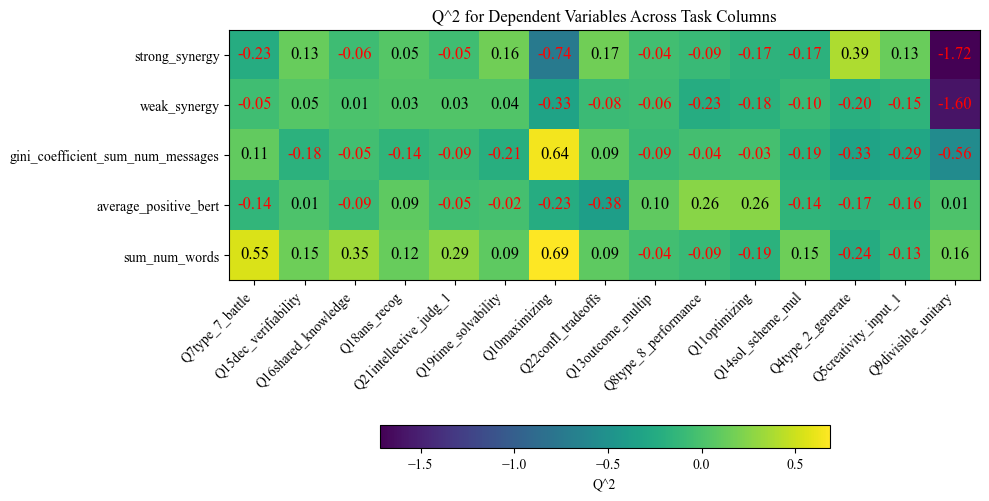

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(q2_by_dv_df, cmap='viridis')  # Set your preferred colormap

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(q2_by_dv_df.columns)))
ax.set_xticklabels(q2_by_dv_df.columns, rotation=45, ha="right")

ax.set_yticks(np.arange(len(dvs)))
ax.set_yticklabels(dvs)

# Loop over data dimensions and create text annotations
for i in range(len(dvs)):
    for j in range(len(q2_by_dv_df.columns)):
        value = q2_by_dv_df.iloc[i, j]
        color = 'black' if value >= 0 else 'red'
        ax.text(j, i, f'{value:.2f}', ha="center", va="center", color=color, fontsize=12)  # Adjust fontsize as needed

ax.set_title("Q^2 for Dependent Variables Across Task Columns")

# Add shorter and horizontal colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink=0.6)
cbar.set_label('Q^2')

fig.tight_layout()
plt.show()

# Exploration of Team Composition Variables
We can aggregate by compositional factors in the same way that we aggregate by task complexity

In [87]:
stage_based_data.data["mostly_male"] = np.where(stage_based_data.composition_features["gender_mean"] >= 0.8, 1, 0)
stage_based_data.data["mostly_female"] = np.where(stage_based_data.composition_features["gender_mean"] <= 0.2, 1, 0)
stage_based_data.data["mixed"] = np.where((stage_based_data.composition_features["gender_mean"] > 0.2) & (stage_based_data.composition_features["gender_mean"] < 0.8), 1, 0)

In [88]:
dvs = ["score", "gini_coefficient_sum_num_messages", "average_positive_bert"]
gender_based_data = stage_based_data.data.groupby(["task_name", "mostly_male", "mostly_female", "mixed"])[dvs].agg("mean").reset_index()

In [89]:
gender_based_data = pd.merge(left = gender_based_data, right = task_map, on = "task_name", how = "left")

In [92]:
def get_q2_per_gender_composition(dv, dv_label):
    dv_to_task_q2 = []
    for gender in ["mostly_male", "mostly_female", "mixed"]:
        dv_by_task_for_gender = gender_based_data[gender_based_data[gender]==1]
        within_complexity_arr = []
        for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
            q2 = get_q2(dv_by_task_for_gender[dv], dv_by_task_for_gender[col])
            within_complexity_arr.append(q2)

        dv_to_task_q2.append(within_complexity_arr)

    plot_q2_heatmap(dv_to_task_q2, ["mostly_male", "mostly_female", "mixed"], dv_label)

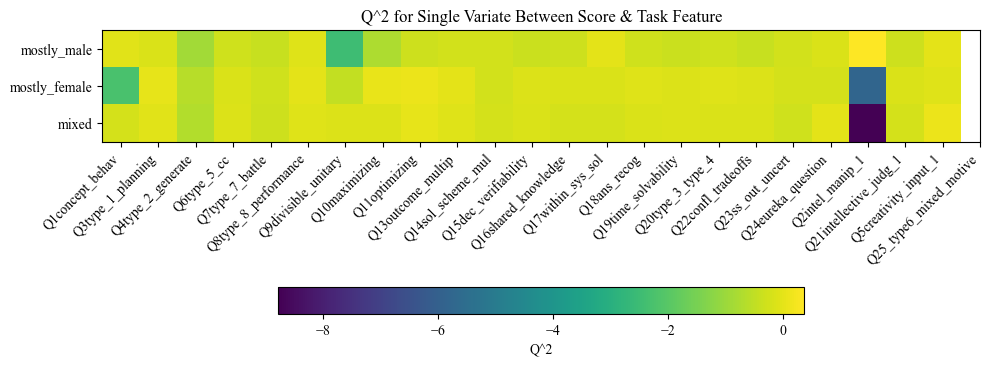

In [93]:
get_q2_per_gender_composition(dv="score", dv_label="Score")

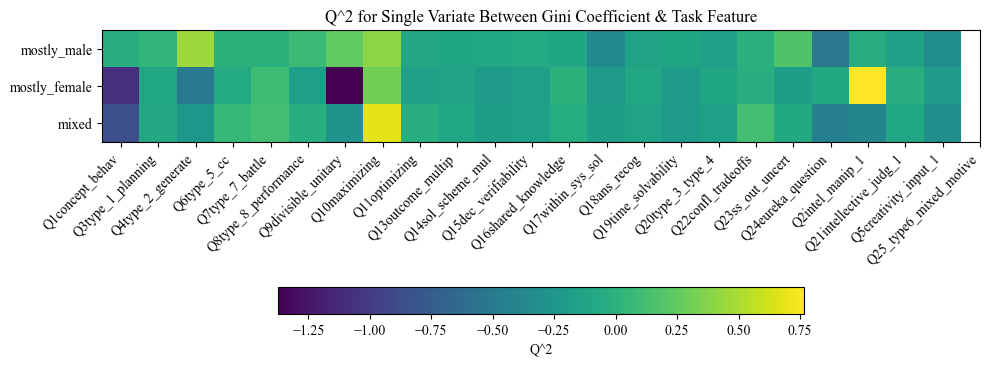

In [94]:
get_q2_per_gender_composition(dv="gini_coefficient_sum_num_messages", dv_label="Gini Coefficient")

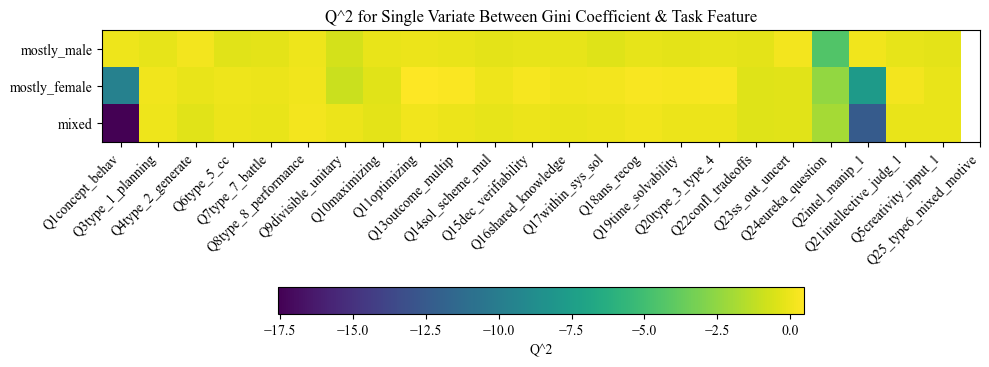

In [96]:
get_q2_per_gender_composition(dv="average_positive_bert", dv_label="Gini Coefficient")

# KNN of the Task Map Itself (as a robustness check; 'us versus McGrath?')